## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weight=0.7):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def mix_loss(y_true, y_pred):
        def focal_loss_fixed(y_true, y_pred):
            """Focal loss for multi-classification
            FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
            """
            epsilon = 1e-8
            y_true = tf.convert_to_tensor(y_true, tf.float32)
            y_pred = tf.convert_to_tensor(y_pred, tf.float32)

            model_out = tf.add(y_pred, epsilon)
            ce = tf.multiply(y_true, -tf.log(model_out))
            weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
            fl = tf.multiply(alpha, tf.multiply(weight, ce))
            reduced_fl = tf.reduce_max(fl, axis=1)
            
            return tf.reduce_mean(reduced_fl)
        
        def ce_loss_fixed(y_true, y_pred):
            return keras.losses.categorical_crossentropy(y_true, y_pred) 

        return ((1. - ce_weight) * focal_loss_fixed(y_true, y_pred)) + (ce_weight * ce_loss_fixed(y_true, y_pred))

    return mix_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [10]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weight=ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00


W0806 21:10:17.068601  4316 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0806 21:10:17.197601  4316 deprecation.py:323] From C:\Users\Hui\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 82us/step - loss: 1.9421 - acc: 0.6567 - val_loss: 3.2185 - val_acc: 0.4773
Epoch 15/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.8469 - acc: 0.6701 - val_loss: 3.2116 - val_acc: 0.4870
Epoch 16/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7575 - acc: 0.6854 - val_loss: 3.2030 - val_acc: 0.4849
Epoch 17/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.6646 - acc: 0.6983 - val_loss: 3.3821 - val_acc: 0.4836
Epoch 18/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5938 - acc: 0.7085 - val_loss: 3.2851 - val_acc: 0.4877
Epoch 19/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5054 - acc: 0.7231 - val_loss: 3.3632 - val_acc: 0.4815
Epoch 20/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.4248 - acc: 0.7360 - val_loss: 3.3501 - val_acc: 0.4857
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 82us/step - loss: 2.5565 - acc: 0.4226 - val_loss: 2.7249 - val_acc: 0.4044
Epoch 3/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.3432 - acc: 0.4645 - val_loss: 2.5144 - val_acc: 0.4297
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.2179 - acc: 0.4923 - val_loss: 2.4336 - val_acc: 0.4416
Epoch 5/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.1134 - acc: 0.5127 - val_loss: 2.3773 - val_acc: 0.4520
Epoch 6/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.0295 - acc: 0.5290 - val_loss: 2.3435 - val_acc: 0.4627
Epoch 7/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.9579 - acc: 0.5429 - val_loss: 2.3473 - val_acc: 0.4649
Epoch 8/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8947 - acc: 0.5552 - val_loss: 2.3180 - val_acc: 0.4661
Epoch 9/25
50000/50000 [============================

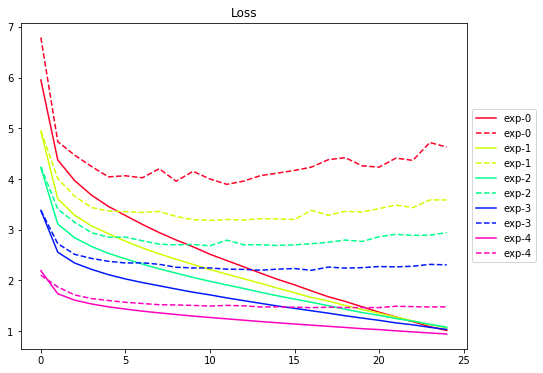

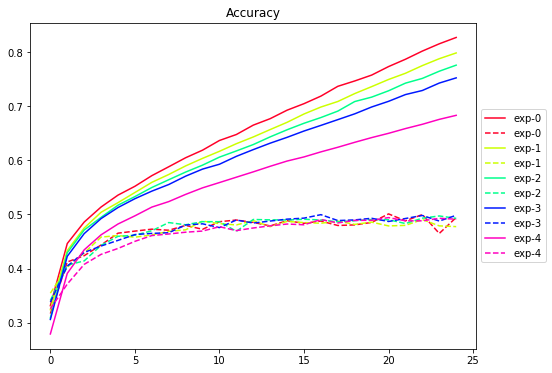

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()